In [3]:
import pandas as pd 
import numpy as np
orders = pd.read_csv("./data/Orders.csv")

# Part I: Preprocessing and EDA

### Problem 1: Dataset Import & Cleaning
Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type.

In [4]:
orders.dtypes

# convert sales and profit to numeric
orders.Sales = orders.Sales.str.replace('$', '').str.replace(',' , '').astype(float).round(2)
orders.Profit = orders.Profit.str.replace('$', '').str.replace(',', '').astype(float).round(2)


### Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

- ***Hint:*** For each order, it has an attribute called `Quantity` that indicates the number of product in the order. If an order contains more than one product, there will be multiple observations of the same order.

In [5]:
import datetime
import seaborn as sns
from matplotlib import pyplot as plt

# convert order date/ship date to datetime object
orders['Order.Date.mod'] = pd.to_datetime(orders['Order.Date']).dt.to_period('M')
orders['Ship.Date.mod'] = pd.to_datetime(orders['Ship.Date']).dt.to_period('M')

# 1. Is there any seasonal trend of inventory in the company?
season = orders[['Quantity', 'Order.Date.mod']].groupby('Order.Date.mod').sum().reset_index()
sns.barplot(x='Order.Date.mod', y='Quantity', data=season)
plt.xticks(rotation=90)
plt.rcParams['figure.figsize']=16,4

# sales seems to be better during winter months and June

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

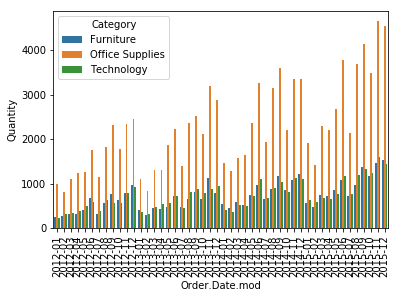

In [6]:
# 2. Is the seasonal trend the same for different categories?

catseason = orders[['Quantity', 'Category', 'Order.Date.mod']].groupby(['Order.Date.mod','Category']).sum().reset_index()
sns.barplot(x='Order.Date.mod', y='Quantity',hue='Category',data=catseason)
plt.xticks(rotation=90)

# Sale of office supplies increased. Sales of furniture and technology items decreased.

### Problem 3: Why did customers make returns?
- Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

	1. How much profit did we lose due to returns each year?


	2. How many customer returned more than once? more than 5 times?


	3. Which regions are more likely to return orders?


	4. Which categories (sub-categories) of products are more likely to be returned?

- ***Hint:*** Merge the **Returns** dataframe with the **Orders** dataframe using `Order.ID`.

In [7]:
returns = pd.read_csv("./data/Returns.csv")

In [8]:
combine = pd.merge(orders, returns, left_on='Order.ID', right_on='Order ID', how='outer')

# 1. How much profit did we lose due to returns each year?
# new df that drop all NaN in returns
combine['Order.Date.year'] = pd.to_datetime(combine['Order.Date']).dt.year
returninfo = combine[combine['Returned']=='Yes']
returninfo[['Order.Date.year','Profit']].groupby('Order.Date.year').sum()

,Profit
Order.Date.year,
2012,17477.26
2013,9269.89
2014,17510.63
2015,17112.97


In [9]:
# 2. How many customer returned more than once? more than 5 times?

returnnum = returninfo[['Returned','Customer.ID']].groupby('Customer.ID').count().reset_index()
returnnum[returnnum['Returned']>5].shape
returnnum[returnnum['Returned']>1].shape

(547, 2)

In [10]:
# 3. Which regions are more likely to return orders?
returninfo[['Returned','Region_y']].groupby('Region_y').count().reset_index().sort_values('Returned', ascending=False)
# Central America

,Region_y,Returned
2,Central America,248
22,Western Europe,233
23,Western US,180
12,Oceania,154
14,Southeastern Asia,140
9,Eastern US,134
13,South America,133
6,Eastern Asia,131
17,Southern Europe,112
16,Southern Asia,111


In [11]:
# 4. Which categories (sub-categories) of products are more likely to be returned?
returninfo[['Returned','Sub.Category']].groupby('Sub.Category').count().reset_index().sort_values('Returned', ascending=False)
# Binders


,Sub.Category,Returned
3,Binders,269
2,Art,217
14,Storage,212
12,Paper,150
5,Chairs,147
13,Phones,145
0,Accessories,138
10,Labels,137
9,Furnishings,135
4,Bookcases,104


# Part II: Machine Learning and Business Use Case

### Problem 4: Feature Engineering

In [12]:
# step 1 & step 2
combine.Returned = pd.get_dummies(combine.Returned)
combine['Order.Month'] = pd.to_datetime(combine['Order.Date']).dt.month
combine['Process.Time'] = pd.to_datetime(combine['Ship.Date']) - pd.to_datetime(combine['Order.Date'])
combine['Process.Time'] = combine['Process.Time'].dt.days

In [13]:
# step 3 Let us generate a feature indictes how many times the product has been returned before
combine ['Return.Freq'] = combine.groupby('Product.ID')['Returned'].transform('sum')

In [14]:
combine.head()

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,...,Order.Priority,Order.Date.mod,Ship.Date.mod,Returned,Order ID,Region_y,Order.Date.year,Order.Month,Process.Time,Return.Freq
0,40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,High,2014-11,2014-11,0,NaN,NaN,2014,11,2,0
1,40099,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,High,2014-11,2014-11,0,NaN,NaN,2014,11,2,0
2,26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,Critical,2014-02,2014-02,0,NaN,NaN,2014,2,2,2
3,26339,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,Critical,2014-02,2014-02,0,NaN,NaN,2014,2,2,1
4,26340,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,Critical,2014-02,2014-02,0,NaN,NaN,2014,2,2,0


In [18]:
use_columns = ['Sales', 'Quantity', 'Discount', 'Process.Time', 'Return.Freq', 'Shipping.Cost', 'Segment',
               'Ship.Mode', 'Region_x', 'Category', 'Order.Month', 'Order.Priority','Profit']
x = pd.get_dummies(combine[use_columns], drop_first=True, dummy_na=True)
y = combine['Returned']


,Sales,Quantity,Discount,Process.Time,Return.Freq,Shipping.Cost,Order.Month,Profit,Segment_Corporate,Segment_Home Office,...,Region_x_Western Europe,Region_x_Western US,Region_x_nan,Category_Office Supplies,Category_Technology,Category_nan,Order.Priority_High,Order.Priority_Low,Order.Priority_Medium,Order.Priority_nan
0,221.98,2,0.00,2,0,40.770,11,62.15,0,0,...,0,0,0,0,1,0,1,0,0,0
1,341.96,2,0.00,2,0,25.270,11,54.71,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3709.40,9,0.10,2,2,923.630,2,-288.77,1,0,...,0,0,0,0,0,0,0,0,0,0
3,344.68,2,0.10,2,1,65.350,2,34.42,1,0,...,0,0,0,0,1,0,0,0,0,0
4,133.92,5,0.10,2,0,41.640,2,-6.03,1,0,...,0,0,0,1,0,0,0,0,0,0
5,70.79,2,0.10,2,0,10.480,2,25.13,1,0,...,0,0,0,0,1,0,0,0,0,0
6,5175.17,9,0.10,1,2,915.490,10,919.97,0,0,...,0,0,0,0,1,0,0,0,1,0
7,333.15,3,0.10,1,1,71.020,10,88.80,0,0,...,0,0,0,0,1,0,0,0,1,0
8,64.15,6,0.10,1,2,5.980,10,22.03,0,0,...,0,0,0,1,0,0,0,0,1,0
9,16.04,2,0.10,1,3,2.250,10,-1.30,0,0,...,0,0,0,1,0,0,0,0,1,0


### Problem 5: Fitting Models

In [372]:
# factorized categorical col
class LabelCountEncoder(object):
    def __init__(self):
        self.count_dict = {}
        
    def fit(self, column):
        # This gives you a dictionary with level as the key and counts as the value
        count = column.value_counts().to_dict()
        # We want to rank the key by its value and use the rank as the new value
        # Your code here
        self.count_dict = dict([(key[0], rank+1) for rank, key in enumerate(sorted(count.items(), key = lambda x: x[1]))])
        
    def transform(self, column):
        # If a category only appears in the test set, we will assign the value to zero.
        missing = 0
        # Your code here
        return column.map(lambda x: self.count_dict.get(x, missing)) # if the key:value pair is not found in the dictionary, fill the value with missing(0)
    
    def fit_transform(self, column):
        self.fit(column)
        return self.transform(column)

In [373]:
# factorized categorical col with obj dtype

label_count_df = x.copy()

key_val_rank ={}
for c in label_count_df.columns:
    if label_count_df[c].dtype == 'object':
        lce = LabelCountEncoder()  # objects are instances of a class. We create an instance by calling the class.
        label_count_df[c] = lce.fit_transform(label_count_df[c])
       

In [375]:
np.random.seed(0)
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, roc_auc_score

skf = StratifiedKFold(n_splits=5)

LR = linear_model.LogisticRegression(class_weight='balanced')
LR.set_params(penalty='l1')


for train_index, test_index in skf.split(label_count_df, y):
    x_train, x_test = label_count_df.iloc[train_index], label_count_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    LR.fit(x_train, y_train)
    y_predict = LR.predict(x_test)
    
    print([LR.coef_, LR.intercept_])
    print(LR.score(x_train, y_train))
    print(confusion_matrix(y_test, y_predict))
    print(roc_auc_score(y_test, y_predict))

[array([[-2.51553479e-04, -8.25943771e-03,  2.54445203e-01,
        -1.97819035e-02,  8.48438718e-01,  4.26019393e-04,
         1.08786757e-02,  5.07857175e-04, -8.04051138e-02,
        -1.01120425e-01,  0.00000000e+00, -6.28253534e-02,
         5.00434738e-02,  1.93926159e-01,  0.00000000e+00,
         0.00000000e+00, -3.49255920e-01,  1.78376185e-01,
        -4.40778573e-01,  2.58725020e-01, -3.81088213e-01,
         2.21462348e-01, -3.31578097e-01,  7.77755606e-01,
        -1.58219367e-01, -1.24900481e-02, -9.08547805e-02,
         7.44040174e-02, -6.34059968e-02,  1.15770466e-01,
         1.26441257e-01,  8.92452176e-02,  8.27573649e-01,
        -7.67702384e-03, -2.55500207e-02, -4.06010057e-01,
         9.58363378e-01,  0.00000000e+00, -2.32181129e-01,
         1.32370740e-01,  0.00000000e+00, -2.23864507e-01,
        -4.92137766e-02, -1.71629871e-01,  0.00000000e+00]]), array([-1.12217628])]
0.7328670306102554
[[7321 2493]
 [ 210  234]]
0.6365010822928083
[array([[-1.40069001e-04

# Problem 6: Evaluating Models